In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

merged = pd.read_csv('/Users/sa2/Desktop/TKH/The-CyberChase/DATA/feb5-12_merged.csv')

In [2]:
dfnum = merged[['Flow Duration',
                  'Flow Bytes/s',
                  'Flow Packets/s',
                  'Packet Length Min',
                  'Packet Length Max',
                  'Packet Length Mean',
                  'Packet Length Std',
                  'Packet Length Variance',
                  'Average Packet Size',
                  'Active Mean',
                  'Active Std',
                  'Active Max',
                  'Active Min',
                  'Idle Std',
                  'Idle Mean',
                  'Idle Max',
                  'Idle Min',
                  'Down/Up Ratio']]
dfnum.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739215 entries, 0 to 1739214
Data columns (total 18 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Flow Duration           int64  
 1   Flow Bytes/s            float64
 2   Flow Packets/s          float64
 3   Packet Length Min       float64
 4   Packet Length Max       float64
 5   Packet Length Mean      float64
 6   Packet Length Std       float64
 7   Packet Length Variance  float64
 8   Average Packet Size     float64
 9   Active Mean             float64
 10  Active Std              float64
 11  Active Max              float64
 12  Active Min              float64
 13  Idle Std                float64
 14  Idle Mean               float64
 15  Idle Max                float64
 16  Idle Min                float64
 17  Down/Up Ratio           float64
dtypes: float64(17), int64(1)
memory usage: 238.8 MB


In [3]:
dfcat = merged.select_dtypes(include=['object'])
dfcat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739215 entries, 0 to 1739214
Data columns (total 5 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   Flow ID    object
 1   Src IP     object
 2   Dst IP     object
 3   Timestamp  object
 4   Label      object
dtypes: object(5)
memory usage: 66.3+ MB


In [4]:
import geoip2.database
from geopy.geocoders import Nominatim


reader = geoip2.database.Reader('/Users/sa2/Desktop/TKH/The-CyberChase/DATA/GeoLite2-City.mmdb')
# Build location info
locations = []
for ip in dfcat['Src IP']:
    try:
        response = reader.city(ip)
        country = response.country.name or "Unknown Country"
        location_str = f"{country}"
    except Exception as e:
        location_str = f"Error: {e}"
    locations.append(location_str)
# Add to DataFrame
dfcat['Src Location'] = locations

locations = []
for ip in dfcat['Dst IP']:
    try:
        response = reader.city(ip)
        country = response.country.name or "Unknown Country"
        location_str = f"{country}"
    except Exception as e:
        location_str = f"Error: {e}"
    locations.append(location_str)

dfcat['Dst Location'] = locations

In [5]:
import pycountry as pc

def country_to_continent(country_name: str) -> str:
    try:
        alpha2 = pc.country_name_to_country_alpha2(country_name)
        code = pc.country_alpha2_to_continent_code(alpha2)
        name = pc.convert_continent_code_to_continent_name(code)
        return name
    except Exception:
        return 'Unknown'

dfcat['Continents'] = dfcat['Src Location'].apply(country_to_continent)

In [6]:
dfcat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739215 entries, 0 to 1739214
Data columns (total 8 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Flow ID       object
 1   Src IP        object
 2   Dst IP        object
 3   Timestamp     object
 4   Label         object
 5   Src Location  object
 6   Dst Location  object
 7   Continents    object
dtypes: object(8)
memory usage: 106.2+ MB


In [7]:
strong_corr = (dfnum.corr().abs() >= 0.7) & (dfnum.corr().abs() < 1.0) 

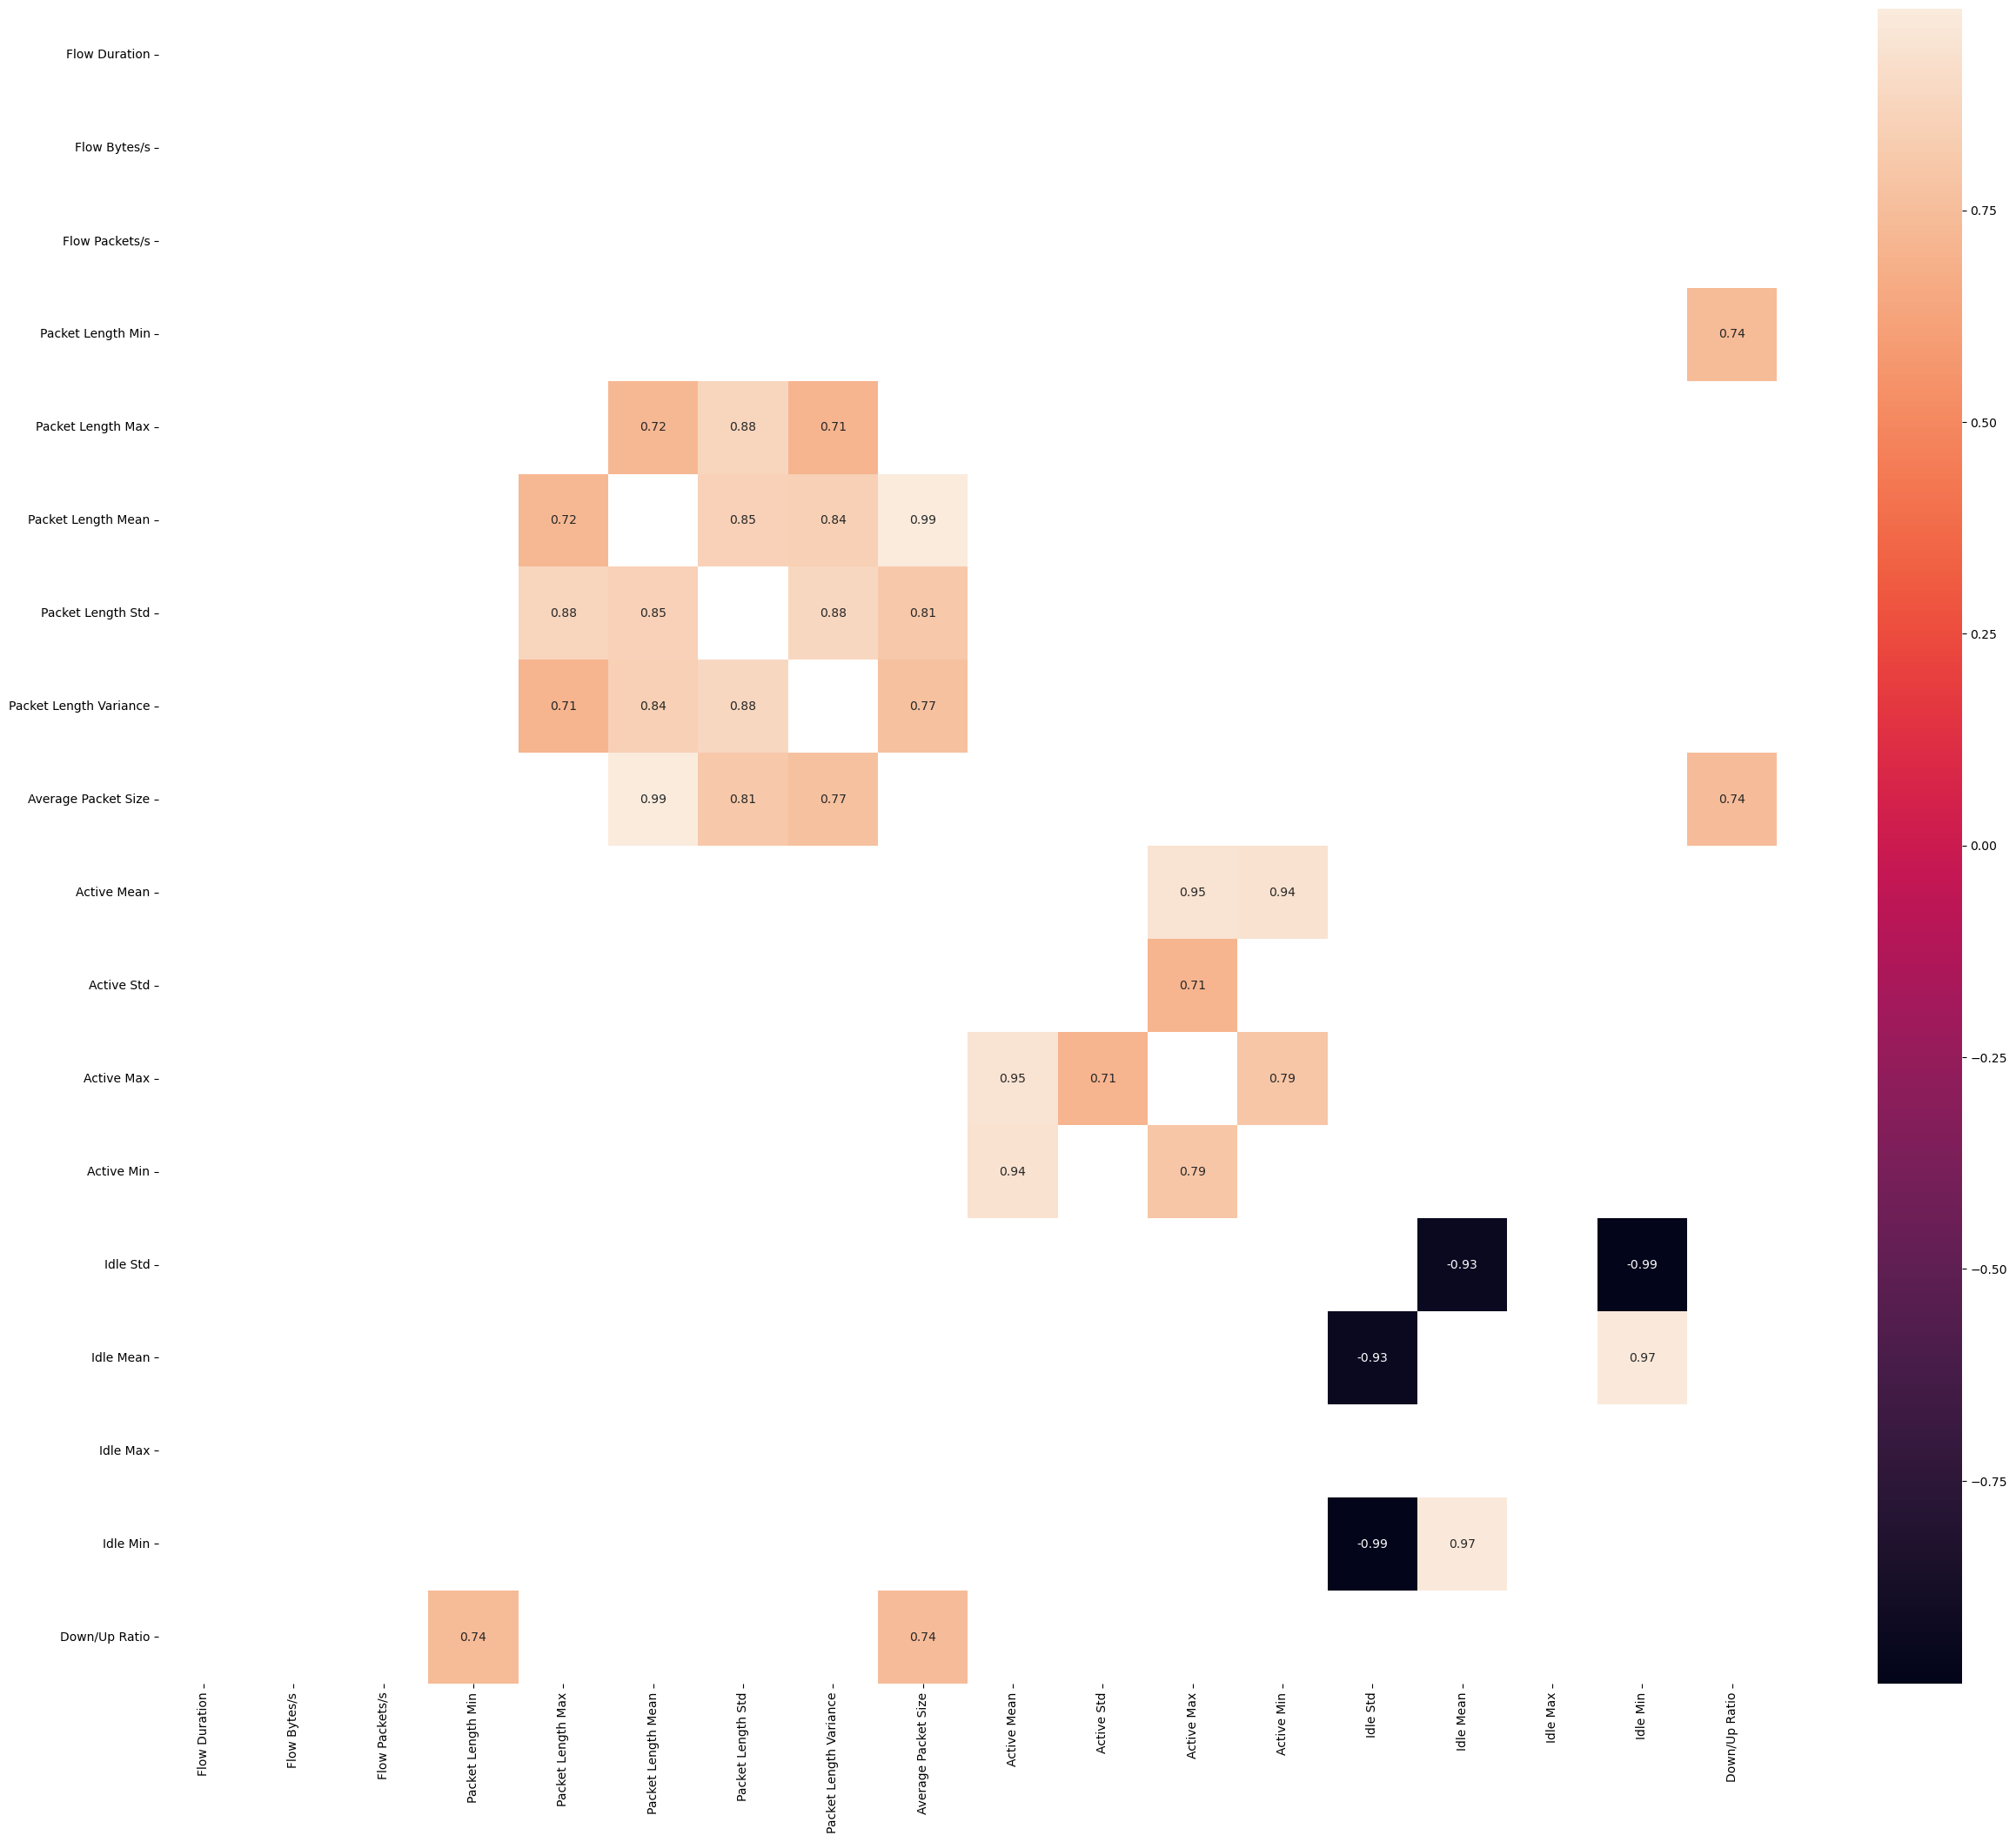

In [8]:
plt.figure(figsize=(30, 25))
sns.heatmap(dfnum.corr().where(strong_corr), annot=True)
plt.show()

In [9]:
# where keeps strong values, stack to get pairs
strong_pairs = dfnum.corr().where(strong_corr).stack().reset_index()

# rename
strong_pairs.columns = ['Feature1', 'Feature2', 'Correlation']

# remove duplicate pairs 
strong_pairs = strong_pairs[strong_pairs['Feature1'] < strong_pairs['Feature2']]

print(strong_pairs.to_string())

               Feature1                Feature2  Correlation
1     Packet Length Max      Packet Length Mean     0.721330
2     Packet Length Max       Packet Length Std     0.876594
3     Packet Length Max  Packet Length Variance     0.706511
5    Packet Length Mean       Packet Length Std     0.853202
6    Packet Length Mean  Packet Length Variance     0.842012
10    Packet Length Std  Packet Length Variance     0.884728
16  Average Packet Size      Packet Length Mean     0.988260
17  Average Packet Size       Packet Length Std     0.806591
18  Average Packet Size  Packet Length Variance     0.769910
19  Average Packet Size           Down/Up Ratio     0.744551
21          Active Mean              Active Min     0.941326
23           Active Max             Active Mean     0.947006
24           Active Max              Active Std     0.708517
25           Active Max              Active Min     0.792052
30            Idle Mean                Idle Std    -0.931634
31            Idle Mean 

drop:
- Packet Length Max
- Packet Length Std
- Packet Length Variance
- Average Packet Size 
&emsp;

captured by Packet Length Mean

&nbsp;

drop:
- Active Min
- Active Max
- Active Std
&emsp;

captured by Active Mean

&nbsp;

drop:
- Idle Min
- Idle Std
&emsp;

captured by Idle Mean

In [10]:
dfnumreduced = dfnum.drop(columns=['Packet Length Max','Packet Length Std','Packet Length Variance','Average Packet Size','Active Min','Active Max','Active Std','Idle Min', 'Idle Std'])
dfnumreduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1739215 entries, 0 to 1739214
Data columns (total 9 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Flow Duration       int64  
 1   Flow Bytes/s        float64
 2   Flow Packets/s      float64
 3   Packet Length Min   float64
 4   Packet Length Mean  float64
 5   Active Mean         float64
 6   Idle Mean           float64
 7   Idle Max            float64
 8   Down/Up Ratio       float64
dtypes: float64(8), int64(1)
memory usage: 119.4 MB


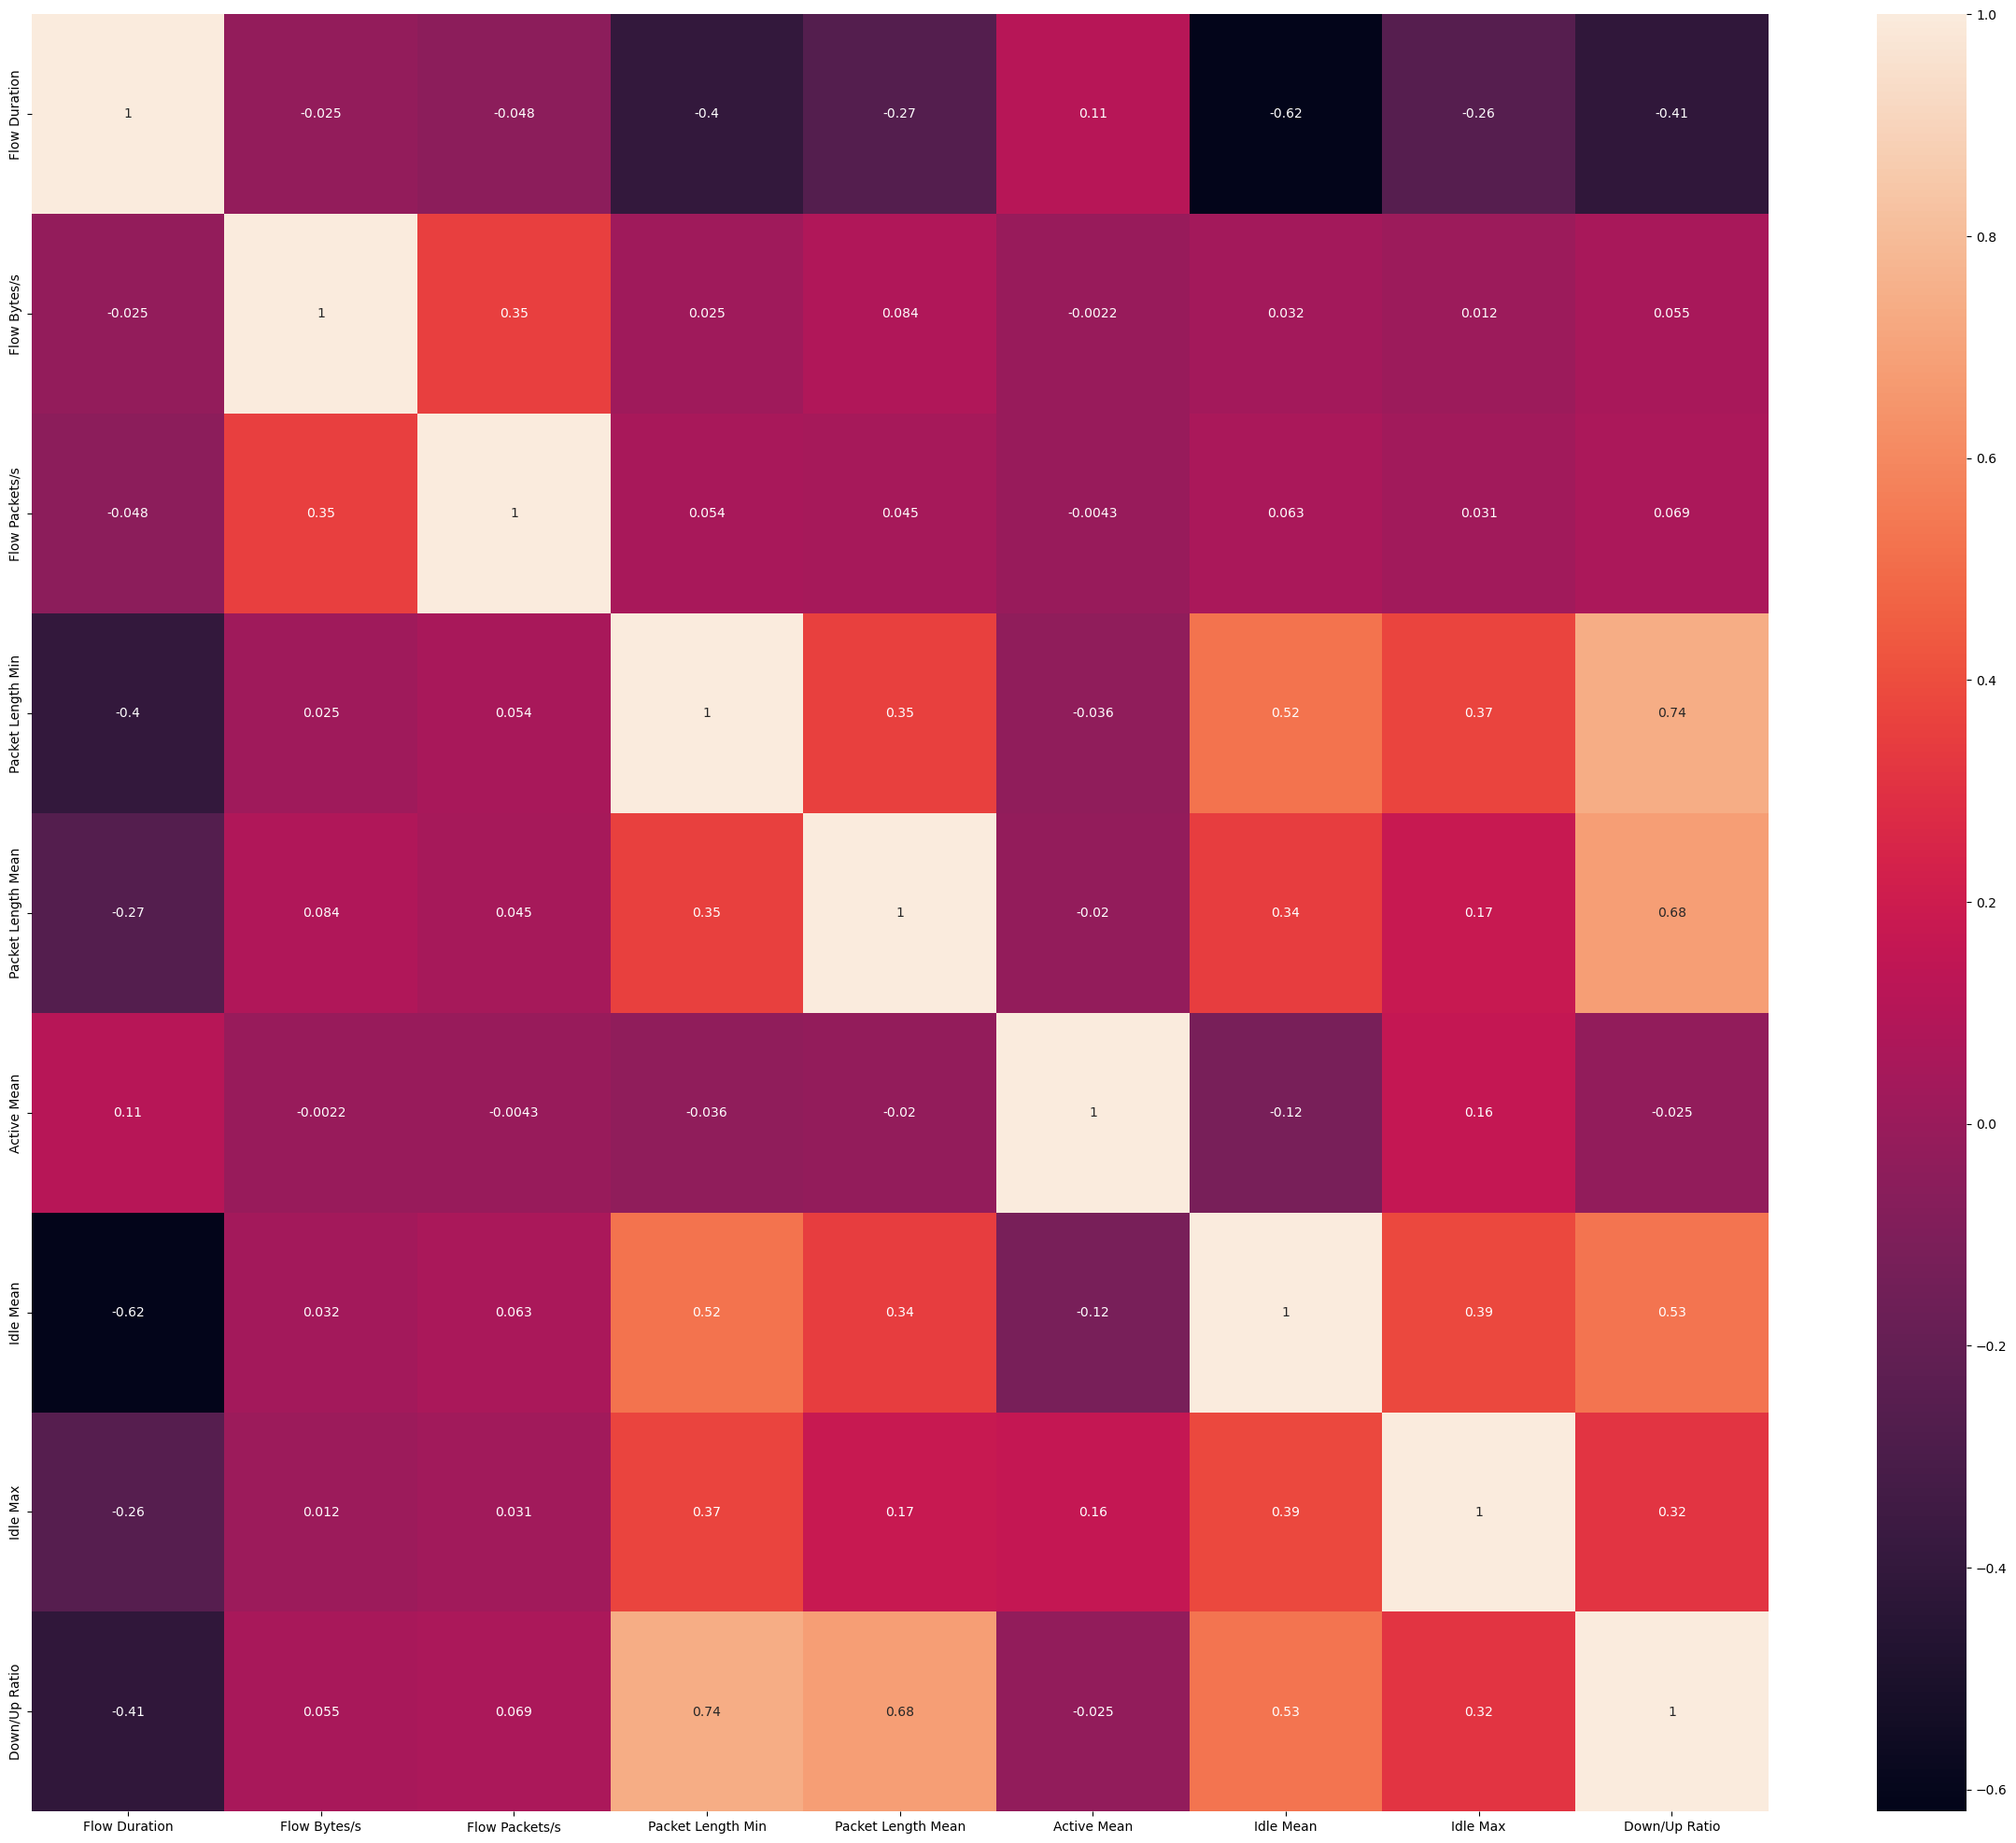

In [11]:
plt.figure(figsize=(30, 25))
sns.heatmap(dfnumreduced.corr(), annot=True)
plt.show()

In [12]:
# where keeps strong values, stack to get pairs
dfnumreduced = dfnumreduced.corr().stack().reset_index()

# rename
dfnumreduced.columns = ['Feature1', 'Feature2', 'Correlation']

# remove duplicate pairs 
dfnumreduced = dfnumreduced[dfnumreduced['Feature1'] < dfnumreduced['Feature2']]

print(dfnumreduced.to_string())

              Feature1            Feature2  Correlation
2        Flow Duration      Flow Packets/s    -0.048080
3        Flow Duration   Packet Length Min    -0.401852
4        Flow Duration  Packet Length Mean    -0.265041
6        Flow Duration           Idle Mean    -0.619857
7        Flow Duration            Idle Max    -0.256059
9         Flow Bytes/s       Flow Duration    -0.024521
11        Flow Bytes/s      Flow Packets/s     0.348652
12        Flow Bytes/s   Packet Length Min     0.025294
13        Flow Bytes/s  Packet Length Mean     0.084045
15        Flow Bytes/s           Idle Mean     0.031953
16        Flow Bytes/s            Idle Max     0.011526
21      Flow Packets/s   Packet Length Min     0.053696
22      Flow Packets/s  Packet Length Mean     0.044690
24      Flow Packets/s           Idle Mean     0.062700
25      Flow Packets/s            Idle Max     0.030975
39  Packet Length Mean   Packet Length Min     0.354696
45         Active Mean       Flow Duration     0

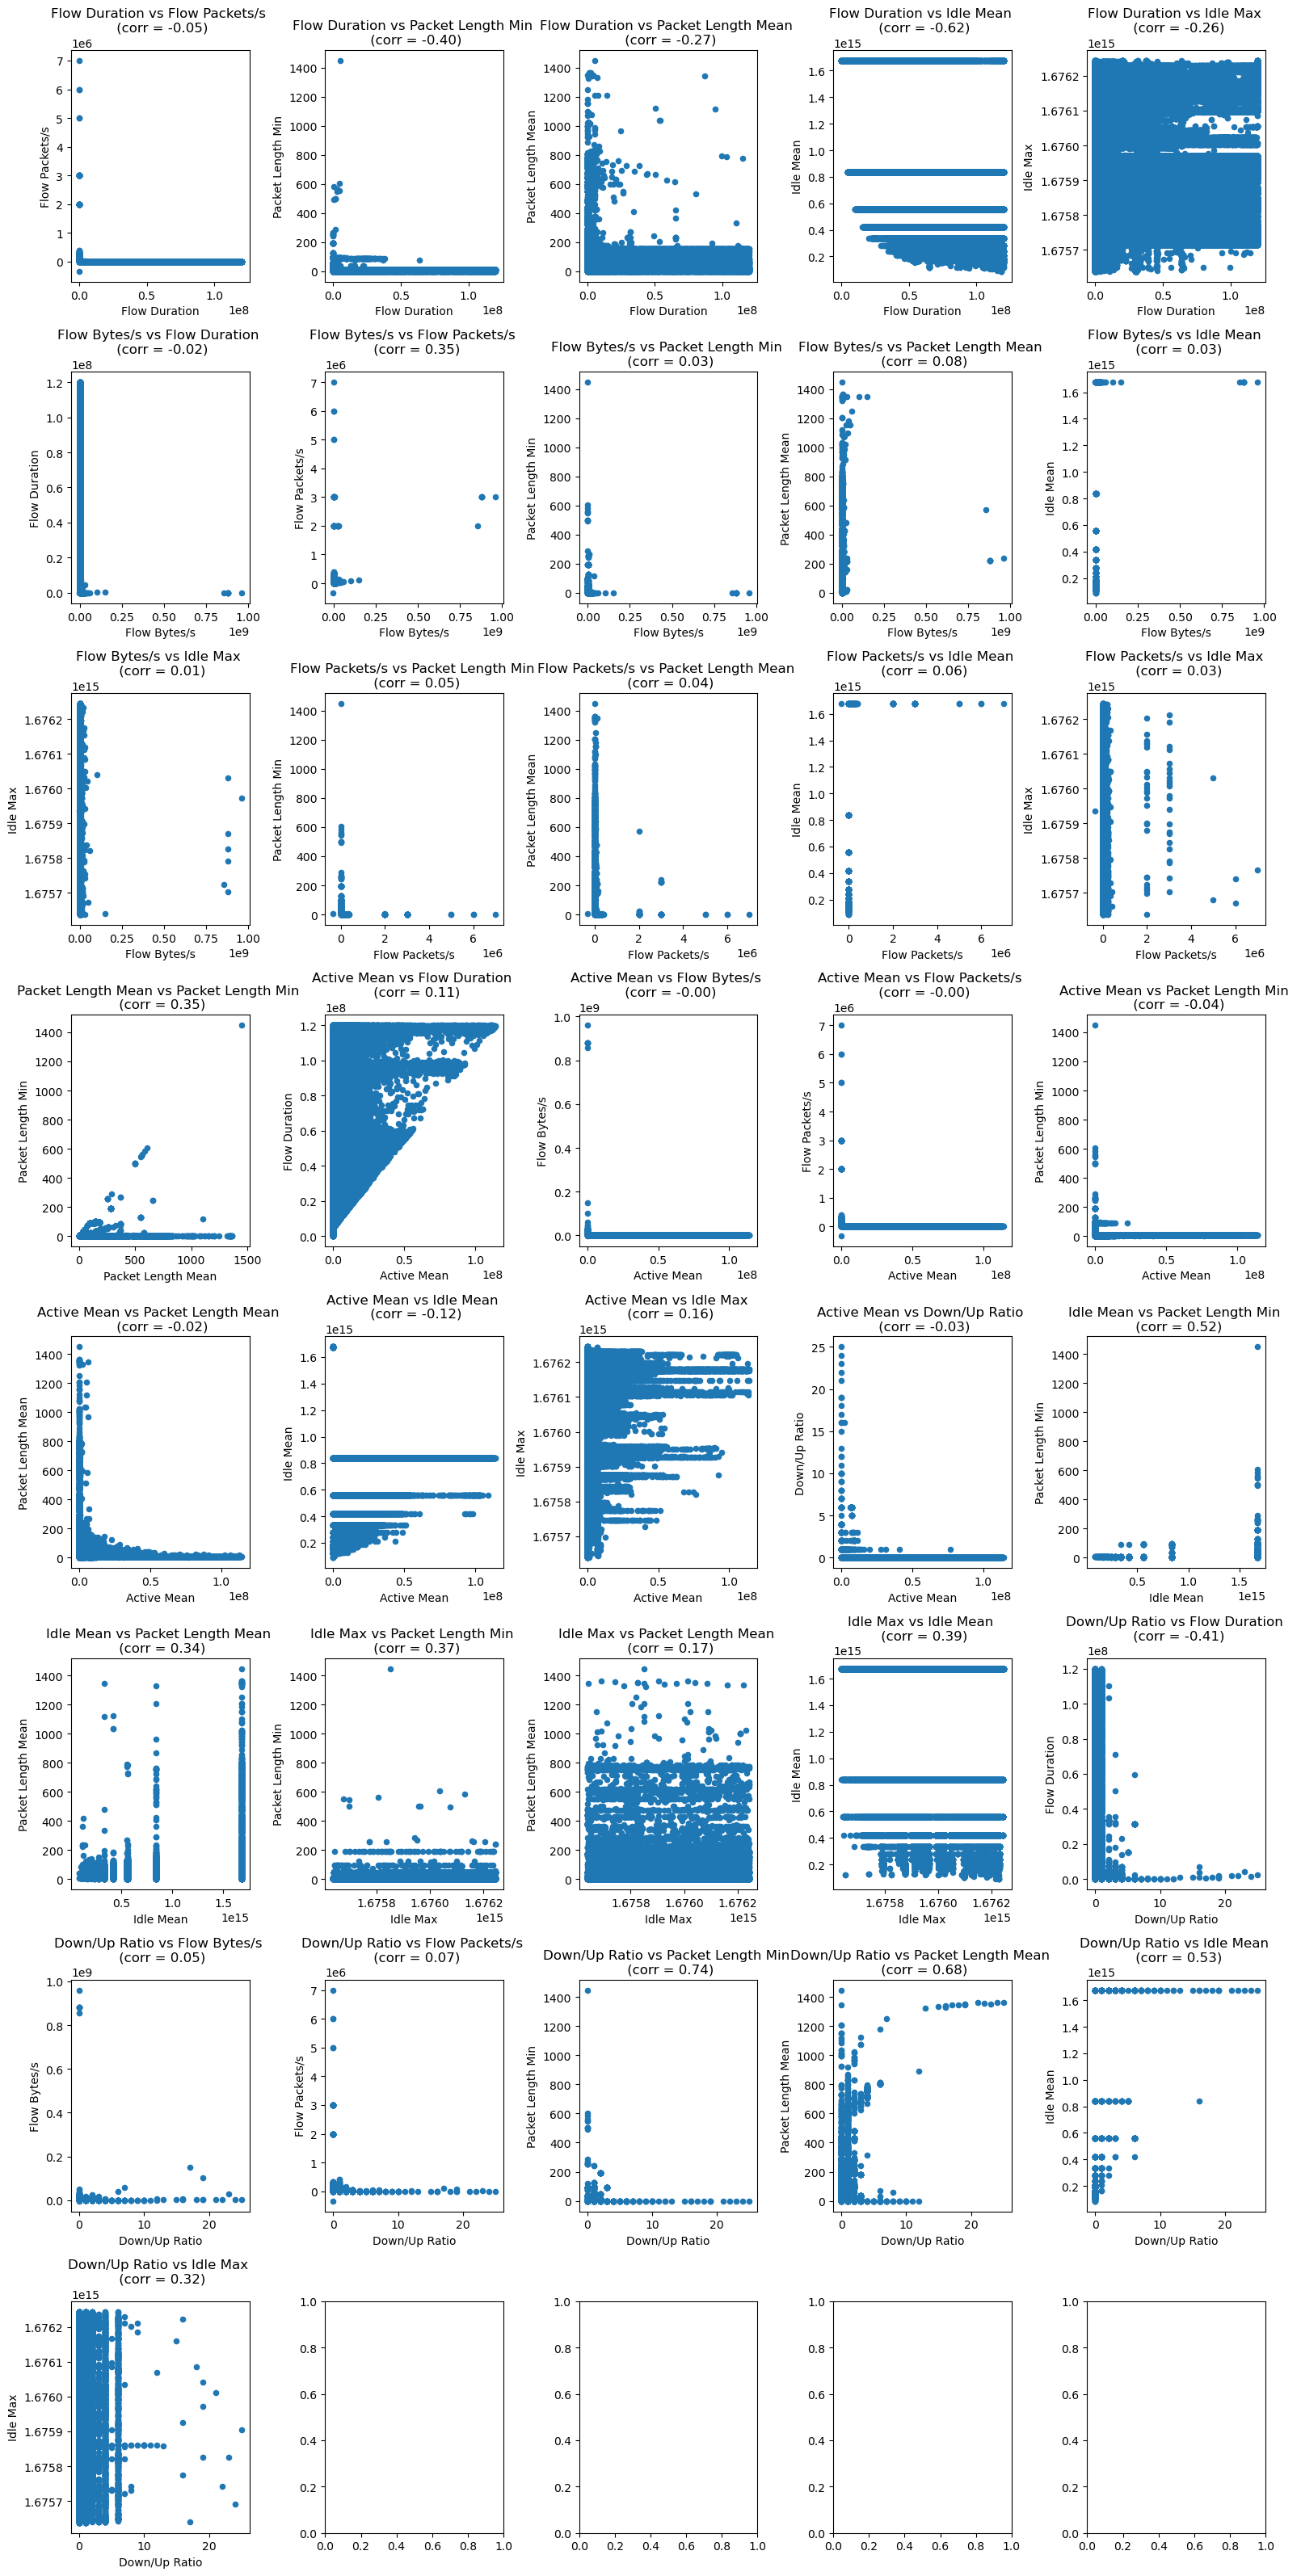

In [13]:
# grid dimensions
rows = (40 + 5 - 1) // 5 

# subplots
fig, axes = plt.subplots(rows, 5, figsize=(16, 4 * rows))
axes = axes.flatten()

# scatter plot
for i, row in enumerate(dfnumreduced.itertuples()):
    feature1 = row.Feature1
    feature2 = row.Feature2
    corr = row.Correlation

    dfnum.plot(kind='scatter', x=feature1, y=feature2, ax=axes[i])
    axes[i].set_title(f'{feature1} vs {feature2} \n (corr = {corr:.2f})')
    axes[i].set_xlabel(feature1)
    axes[i].set_ylabel(feature2)

plt.tight_layout()
plt.show()

In [14]:
# Combine dfnum and the 'continent' column from dfcat
df_combined = dfnum.copy()
df_combined['Continents'] = dfcat['Continents']